In [130]:
import pandas as pd
import numpy as np

from clustering_functions import *
from impute_transform import ImputeTransform
from fancyimpute import MatrixFactorization

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
plt.style.use('ggplot')

# Unsupervised Learning in ADHD

## Introduction

## Overview of Methods

## Overview of Results (?)

---

# TMCQ Cluster Analysis

## Prepare Data

Participants with any null TMCQ values are dropped.

In [46]:
data = pd.read_csv('data/full_data.csv')
#small_data = data.sample(n=200)
TMCQ_all, TMCQ_adhd, TMCQ_control = prep_data(data, dataset='TMCQ')

In [47]:
print_ns(TMCQ_all, TMCQ_adhd, TMCQ_control)

Ns for each group
-----------------
All:      888
ADHD:     564
Control:  324


## Choose K for each group

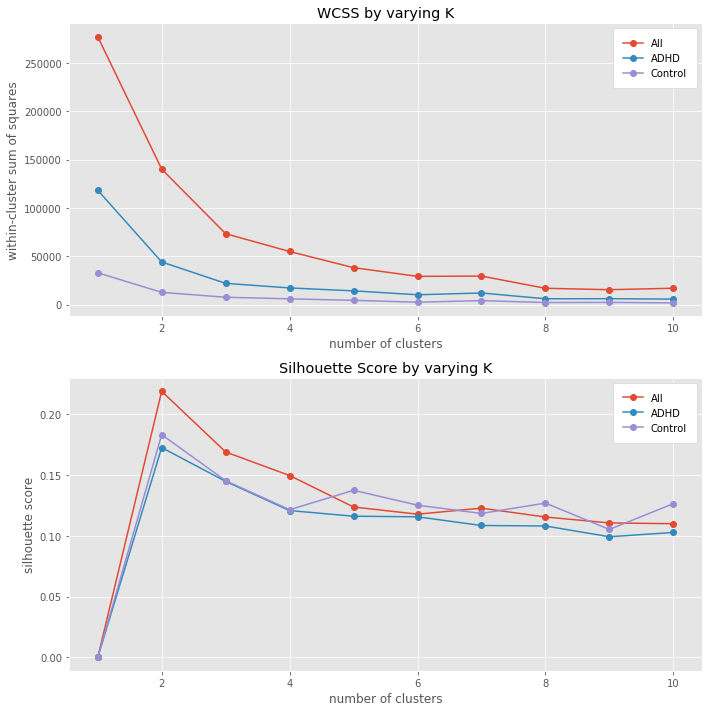

In [7]:
fig, axs = plt.subplots(2,1,figsize=(10,10))
km = KMeans(n_jobs=-1)
wcss_and_silhouette(TMCQ_all, km, axs, 'All')
wcss_and_silhouette(TMCQ_adhd, km, axs, 'ADHD')
wcss_and_silhouette(TMCQ_control, km, axs, 'Control')
plt.tight_layout()

2 seems to be the best number of clusters for all groups.

## Group = All, K = 2

What kind of insights can we gain from the KMeans Cluster Analysis on the TMCQ dataset with all subjects?

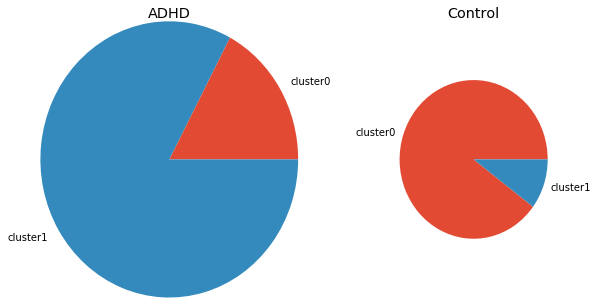

In [105]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
km = KMeans(n_clusters=2, n_jobs=-1, random_state=56)
build_piechart(TMCQ_all, data, km, 'DX', axs)

Here we can see that Cluster 0 roughly corresponds to Control, and Cluster 1 roughly corresponds to ADHD.

Radius of the pie chart is: (N of the diagnosis group / total N) * 2

Below is proportions of clusters per DX group for DXSUB.

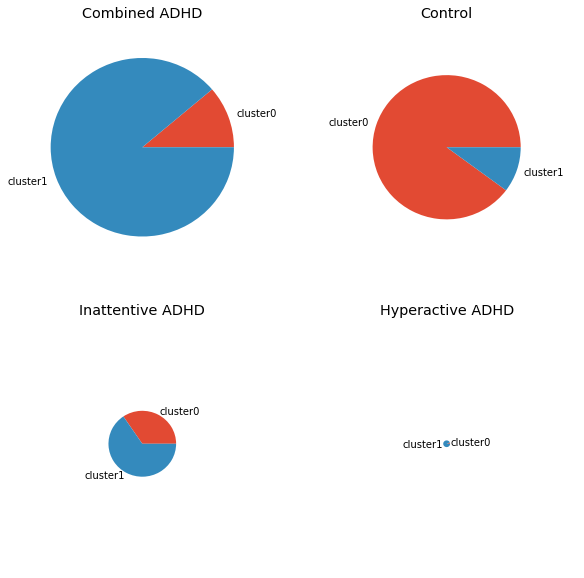

In [109]:
fig, axs = plt.subplots(2,2,figsize=(10,10))
build_piechart(TMCQ_all, data, km, 'DXSUB', axs.flatten(),
               title_dict = {1.0: 'Control', 3.0: 'Inattentive ADHD', 4.0: 'Hyperactive ADHD', 5.0: 'Combined ADHD'})

This is a little less informative (particularly for Inattentive and Hyperactive ADHD because of their low Ns). However we see the same pattern of Cluster 1 corresponding to ADHD subtypes.

## Group = ADHD, Control, K = 2

We will now examine the TMCQ scores. We split the TMCQ dataset into ADHD and Control groups. On each group, we run KMeans(n_clusters=2). We then compare mean TMCQ scores in each cluster between the groups.

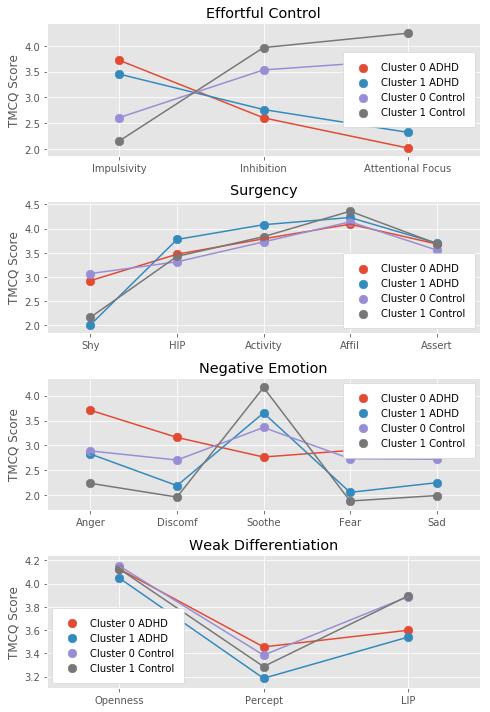

In [118]:
km = KMeans(n_clusters=2, n_jobs=-1, random_state=56)
fig, axs = plt.subplots(4,1,figsize=(7,10))
run_ADHD_Control_k2(TMCQ_adhd, TMCQ_control, km, axs)
plt.tight_layout()

Statistical tests go here

---

# Neuropsych Cluster Analysis

## Prepare Data

Subjects with _all_ null neuropsych values are dropped.

In [131]:
data = pd.read_csv('data/full_data.csv')
small_data = data.sample(n=200)
neuro_all, neuro_adhd, neuro_control = prep_data(small_data, dataset='neuro')

In [132]:
print_ns(neuro_all, neuro_adhd, neuro_control)

Ns for each group
-----------------
All:      200
ADHD:     130
Control:  70


## Choose K for each group

In [ ]:
fig, axs = plt.subplots(2,1,figsize=(10,10))

impute_transform = ImputeTransform(strategy=MatrixFactorization())
scaler = StandardScaler()
kmeans = KMeans(n_jobs=-1)
steps = [('impute_transform', impute_transform),
         ('standard_scaler', scaler),
         ('kmeans', kmeans)]
pipeline = Pipeline(steps)

wcss_and_silhouette(TMCQ_all, pipeline, axs, 'All', standard_scale=True)
wcss_and_silhouette(TMCQ_adhd, pipeline, axs, 'ADHD', standard_scale=True)
wcss_and_silhouette(TMCQ_control, pipeline, axs, 'Control', standard_scale=True)
plt.tight_layout()

Again, 2 seems to be the best number of clusters for all groups.

## Group = All, K = 2

What kind of insights can we gain from the KMeans Cluster Analysis on the neuro dataset with all subjects?

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

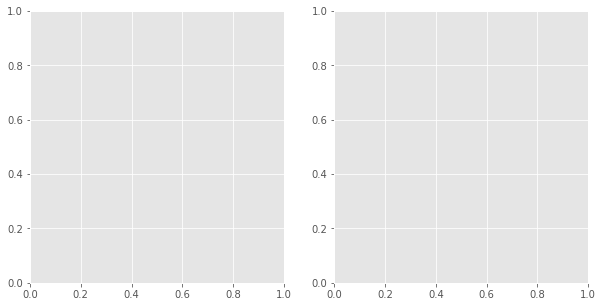

In [126]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
km = KMeans(n_clusters=2, n_jobs=-1, random_state=56)
build_piechart(neuro_all, data, km, 'DX', axs)

Here we can see that Cluster 0 roughly corresponds to Control, and Cluster 1 roughly corresponds to ADHD.

Radius of the pie chart is: (N of the diagnosis group / total N) * 2

Below is proportions of clusters per DX group for DXSUB.

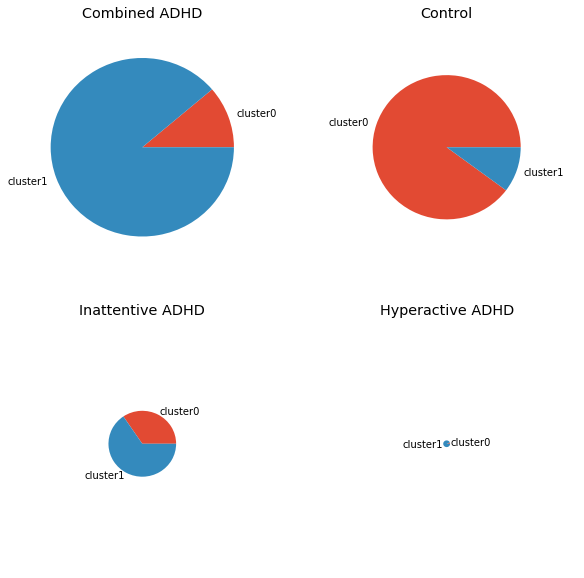

In [109]:
fig, axs = plt.subplots(2,2,figsize=(10,10))
build_piechart(TMCQ_all, data, km, 'DXSUB', axs.flatten(),
               title_dict = {1.0: 'Control', 3.0: 'Inattentive ADHD', 4.0: 'Hyperactive ADHD', 5.0: 'Combined ADHD'})

This is a little less informative (particularly for Inattentive and Hyperactive ADHD because of their low Ns). However we see the same pattern of Cluster 1 corresponding to ADHD subtypes.

## Group = ADHD, Control, K = 2

We will now examine the TMCQ scores. We split the TMCQ dataset into ADHD and Control groups. On each group, we run KMeans(n_clusters=2). We then compare mean TMCQ scores in each cluster between the groups.

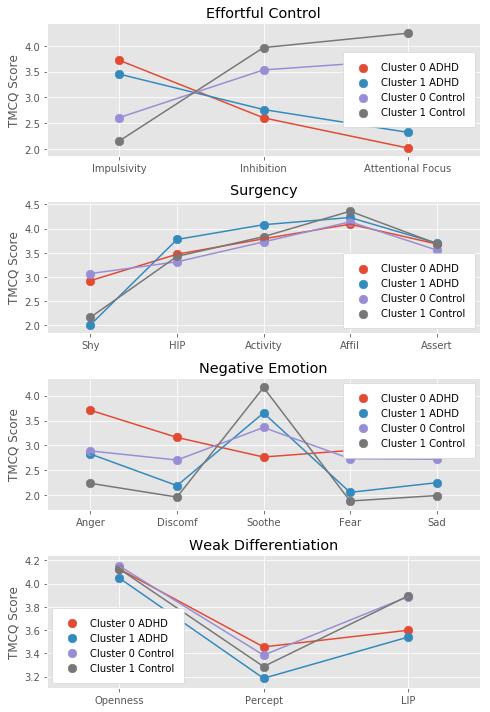

In [118]:
km = KMeans(n_clusters=2, n_jobs=-1, random_state=56)
fig, axs = plt.subplots(4,1,figsize=(7,10))
run_ADHD_Control_k2(TMCQ_adhd, TMCQ_control, km, axs)
plt.tight_layout()

Statistical tests go here

---